In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import mlflow
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
def load_data(file_path):
    """
    Function to load the data.

    Parameters
    ----------
    file_path : csv file
        CSV file with 21 columns and 2000 data rows and one column row.

    Returns
    -------
    df : Pandas Dataframe
        Pandas Dataframe which contains the data from the csv file.
    """
    return pd.read_csv(file_path) 

In [3]:
def check_missing_values(df):
    """
    Function to check whether the DataFrame contains NaN values or missing values.

    Parameters
    ----------
    df : Pandas Dataframe
        Pandas Dataframe which contains the data from the csv file.

    Returns
    -------
    missing_values : boolean
        Answer whether the DataFrame contains NaN values or missing values.
    """

    # Testing whether the DataFrame contains NaN values or missing values
    missing_values = df.isna().any().any()

    # Print the answer
    if missing_values:
        print("Das DataFrame enthält NaN-Werte oder fehlende Werte.")
    else:
        print("Das DataFrame enthält keine NaN-Werte oder fehlende Werte.")
        
    return missing_values

In [4]:
def calculate_correlation_matrix(df):
    """
    Function to calculate and visualize the Pearson correlation coefficients as a heatmap.

    Parameters
    ----------
    df : Pandas Dataframe
        Pandas Dataframe which contains the data from the csv file.
    """
    # Calculate the Pearson correlation coefficients
    correlation_matrix = df.corr()
    
    # Enlarge the plot
    plt.figure(figsize=(16, 9)) 

    # Visualize the Pearson correlation coefficients as a heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

    # Set the title
    plt.title("Correlation Matrix", fontsize=18)

    plt.show()

In [5]:
def prepare_data(df):
    """
    Function to prepare the data for the machine learning model by splitting the data into training, validation and test data.

    Parameters
    ----------
    df : Pandas Dataframe
        Pandas Dataframe which contains the data from the csv file.

    Returns
    -------
    X_train : numpy array
        Contains the features of the training data.
    X_val: numpy array
        Contains the feautres of the validation data.
    x_test : numpy array
        Contains the features of the test data.
    Y_train : numpy array
        Contains the labels of the training data.
    Y_val : numpy array
        Contains the labels of the validation data.
    y_test : numpy array
        Contains the labels of the test data.
    """

    # Assigning the features to the variable X_train
    X_train = np.array(df[['battery_power', 'blue', 'clock_speed', 'fc', 'four_g', 'int_memory',
                                   'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w',
                                   'talk_time', 'three_g', 'touch_screen', 'm_dep', 'mobile_wt', 'dual_sim', 'wifi']]) 
    
    # Assigning the labels to the variable Y_train
    Y_train = np.array(df['price_range'])

    # Splitting the data into training and test data
    X_train_val, x_test, Y_train_val, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

    # Splitting the training data into training and validation data
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

    return X_train, X_val, x_test, Y_train, Y_val, y_test

In [6]:
def find_best_k_and_evaluate(X_train, Y_train, X_val, Y_val, x_test, y_test):
    """
    Function to assign the features and labels to the variables X_train, Y_train, X_val, Y_val, x_test 
    and y_test and to split the data into training, validation and test data and for finding the best k and the best distance metric.

    Parameters
    ----------
    X_train : numpy array
        Contains the features of the training data.
    X_val: numpy array
        Contains the feautres of the validation data.
    x_test : numpy array
        Contains the features of the test data.
    Y_train : numpy array
        Contains the labels of the training data.
    Y_val : numpy array
        Contains the labels of the validation data.
    y_test : numpy array
        Contains the labels of the test data.

    Returns
    -------
    best_k : int
        Contains the best k value.
    test_accuracy : float
        Contains the accuracy of the best KNeighborsClassifier model on the test data.
    best_knn : KNeighborsClassifier
        Contains the best KNeighborsClassifier model.
    best_distance_metric : str
        Contains the best distance metric.
    """
    
    # Set the k values
    k_values = list(range(1, 121))
    
    # Set the distance metrics
    distance_metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']

    # Create a list to store the accuracy scores
    accuracy_scores = []
    
    # Create variables to store the best parameters and metrics
    best_k = 0
    best_accuracy = 0
    best_distance_metric = ''
    best_knn = None

    # Train and evaluate the model
    for k in k_values:
        for metric in distance_metrics:

            # Start a new run
            with mlflow.start_run():

                # Create a KNeighborsClassifier model with k neighbors and specified distance metric
                knn = KNeighborsClassifier(n_neighbors=k, metric=metric)

                # Fit the model to the training data
                knn.fit(X_train, Y_train)

                # Predict the labels of the validation data
                Y_val_pred = knn.predict(X_val)

                # Calculate the accuracy score
                accuracy = accuracy_score(Y_val, Y_val_pred)

                # Append the accuracy score to the list
                accuracy_scores.append(accuracy)

                # Log the parameters and metrics
                mlflow.log_param("k", k)
                mlflow.log_param("distance_metric", metric)
                mlflow.log_metric("accuracy", accuracy, step=k)

                # Check if the accuracy score is the best so far
                if accuracy > best_accuracy:
                    best_k = k
                    best_accuracy = accuracy
                    best_distance_metric = metric
                    best_knn = knn

            # End the run
            mlflow.end_run()

    # Evaluate on test set
    Y_test_pred = best_knn.predict(x_test)
    test_accuracy = accuracy_score(y_test, Y_test_pred)

    # Log the best model
    with mlflow.start_run():
        # Log parameters
        mlflow.log_param("best_k", best_k)
        mlflow.log_param("best_distance_metric", best_distance_metric)

        # Log metrics
        mlflow.log_metric("best_test_accuracy", test_accuracy)

        # Log the model to the "models" directory
        os.makedirs("models", exist_ok=True)
        mlflow.sklearn.log_model(best_knn, "models")

    return best_k, test_accuracy, best_knn, best_distance_metric

In [7]:
def visualize_3d_scatter(df):
    """
    Function to visualize the relation between price, ram and depth of the mobile phones in a 3D scatter plot.

    Parameters
    ----------
    df : Pandas Dataframe
        Pandas Dataframe which contains the data from the csv file.
    """

    # Create a 3D scatter plot
    fig = px.scatter_3d(df, x=df["price_range"], y=df["ram"], z=df["m_dep"], color=df["price_range"])

    # Set the title of the plot
    fig.update_layout(title="Ratio between price, ram and depth")

    fig.show()

Das DataFrame enthält keine NaN-Werte oder fehlende Werte.


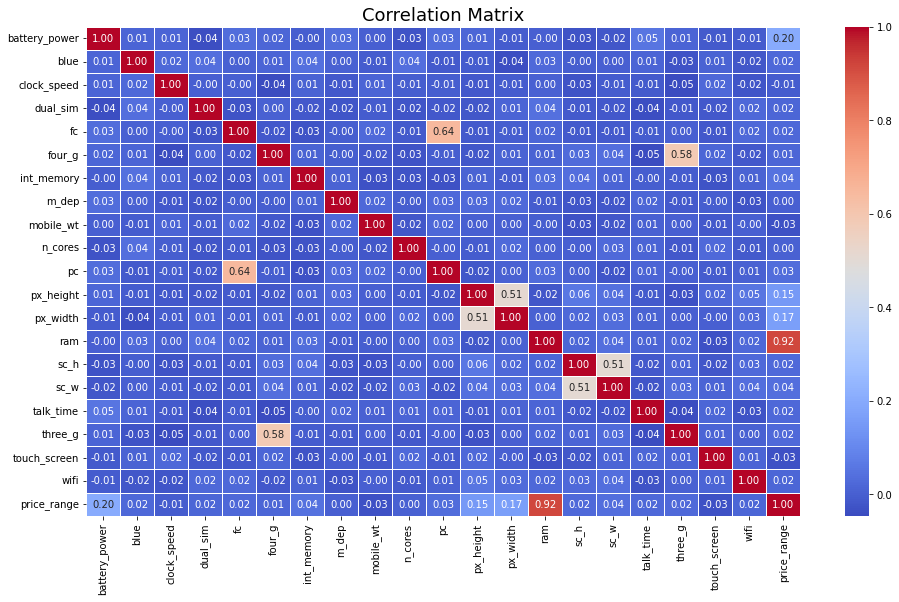

None


Best k: 11
Best Test Accuracy: 0.9475
Best Distance Metric: euclidean


c:\Python310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning:

Setuptools is replacing distutils.



In [8]:
if __name__ == "__main__":
    
    # Load data
    df = load_data("train.csv")

    # Check for missing values
    check_missing_values(df)

    # Calculate and display correlation matrix
    correlation_matrix = calculate_correlation_matrix(df)
    print(correlation_matrix)

    # Prepare data for training and testing
    X_train, X_val, x_test, Y_train, Y_val, y_test = prepare_data(df)

    # Visualize 3D scatter plot
    visualize_3d_scatter(df)

    # Find the best k value and evaluate the model
    best_k, best_test_accuracy, best_knn, best_distance_metric = find_best_k_and_evaluate(X_train, Y_train, X_val, Y_val, x_test, y_test)

    # Print the best k value
    print("Best k:", best_k)

    # Print the best validation accuracy
    print("Best Test Accuracy:", best_test_accuracy)

    # Print the best distance metric
    print("Best Distance Metric:", best_distance_metric)